#### Objective

The objective of this assignment is to familiarize you with building, training, and evaluating a Multi-Layer
Perceptron (MLP) using PyTorch. You will utilize the MNIST dataset, a popular dataset of handwritten
digits, to train your model to recognize digits from 0 to 9.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import time

# Define constants for the model setup
BATCH_SIZE = 64
NUM_EPOCHS = 20
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Data transformation and dataset preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
valid_dataset = datasets.MNIST(root='./data', train=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

# Splitting training dataset into training and validation
validation_fraction = 0.1
num = int(validation_fraction * 60000)
train_indices = torch.arange(0, 60000 - num)
valid_indices = torch.arange(60000 - num, 60000)

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

# Setup DataLoader for training, validation, and test sets
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, drop_last=True, sampler=train_sampler)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, sampler=valid_sampler)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# MLP model definition
class MLP(nn.Module):
    def __init__(self, num_features, num_hidden_1, num_hidden_2, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Flatten(),  # Flatten input for MLP
            nn.Linear(num_features, num_hidden_1),  # First hidden layer
            nn.BatchNorm1d(num_hidden_1),  # Batch normalization
            nn.ReLU(),  # Activation function
            nn.Dropout(0.5),  # Dropout to reduce overfitting
            nn.Linear(num_hidden_1, num_hidden_2),  # Second hidden layer
            nn.BatchNorm1d(num_hidden_2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(num_hidden_2, num_classes)  # Output layer
        )

    def forward(self, x):
        logits = self.network(x)  # Forward pass
        return logits

# Initialize the MLP model
model = MLP(num_features=28*28, num_hidden_1=128, num_hidden_2=64, num_classes=10)
model = model.to(DEVICE)  # Move model to the specified device

# Loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, mode='min')

# Function to compute model accuracy
def compute_accuracy(data_loader):
    with torch.no_grad():
        correct_pred, num_examples = 0, 0
        for _, (features, targets) in enumerate(data_loader):
            features = features.to(DEVICE)
            targets = targets.float().to(DEVICE)
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float() / num_examples * 100

# Training loop
start_time = time.time()
minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []

for epoch in range(NUM_EPOCHS):
    model.train()  # Set model to training mode
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
        logits = model(features)
        loss = criterion(logits, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        minibatch_loss_list.append(loss.item())
        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch+1}/{NUM_EPOCHS} | Batch {batch_idx}/{len(train_loader)} | Loss: {loss:.4f}')
    model.eval()  # Set model to evaluation mode for testing
    train_acc = compute_accuracy(train_loader)
    valid_acc = compute_accuracy(valid_loader)
    train_acc_list.append(train_acc.item())
    valid_acc_list.append(valid_acc.item())
    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} | Train: {train_acc:.2f}% | Validation: {valid_acc:.2f}%')
    scheduler.step(minibatch_loss_list[-1])

elapsed = (time.time() - start_time) / 60
print(f'Total Training Time: {elapsed:.2f} min')

# Evaluate the model on the test dataset
test_acc = compute_accuracy(test_loader)
print(f'Test accuracy: {test_acc:.2f}%')


Epoch: 1/20 | Batch 0/843 | Loss: 2.5339
Epoch: 1/20 | Batch 100/843 | Loss: 0.7489
Epoch: 1/20 | Batch 200/843 | Loss: 0.4707
Epoch: 1/20 | Batch 300/843 | Loss: 0.4088
Epoch: 1/20 | Batch 400/843 | Loss: 0.2097
Epoch: 1/20 | Batch 500/843 | Loss: 0.2808
Epoch: 1/20 | Batch 600/843 | Loss: 0.2887
Epoch: 1/20 | Batch 700/843 | Loss: 0.3910
Epoch: 1/20 | Batch 800/843 | Loss: 0.4040
Epoch: 1/20 | Train: 95.31% | Validation: 96.40%
Epoch: 2/20 | Batch 0/843 | Loss: 0.3342
Epoch: 2/20 | Batch 100/843 | Loss: 0.2271
Epoch: 2/20 | Batch 200/843 | Loss: 0.2663
Epoch: 2/20 | Batch 300/843 | Loss: 0.3261
Epoch: 2/20 | Batch 400/843 | Loss: 0.5428
Epoch: 2/20 | Batch 500/843 | Loss: 0.4165
Epoch: 2/20 | Batch 600/843 | Loss: 0.3048
Epoch: 2/20 | Batch 700/843 | Loss: 0.3032
Epoch: 2/20 | Batch 800/843 | Loss: 0.2727
Epoch: 2/20 | Train: 96.14% | Validation: 96.92%
Epoch: 3/20 | Batch 0/843 | Loss: 0.1377
Epoch: 3/20 | Batch 100/843 | Loss: 0.2373
Epoch: 3/20 | Batch 200/843 | Loss: 0.3676
Epoch

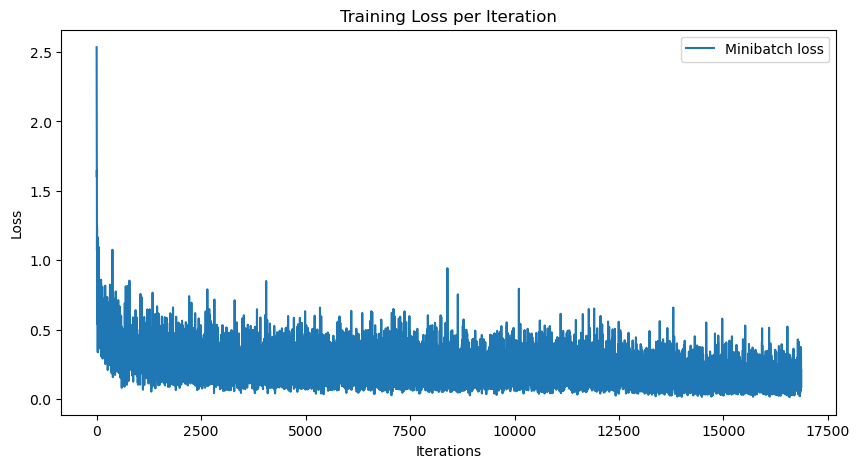

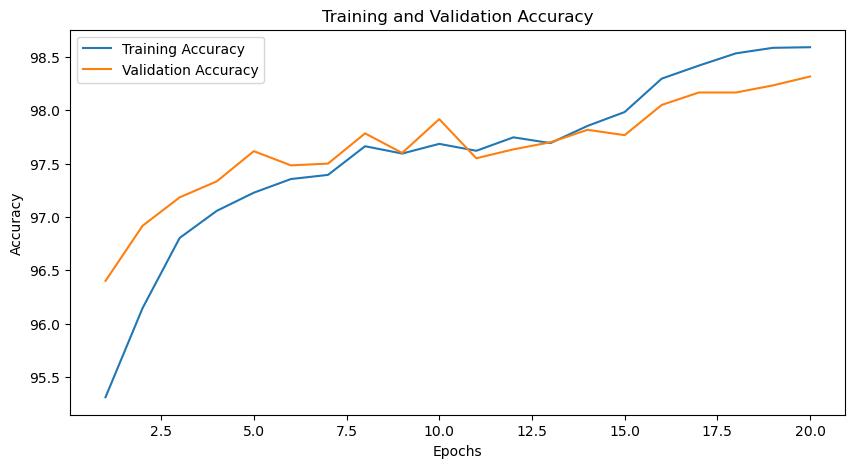

In [5]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(minibatch_loss_list, label='Minibatch loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss per Iteration')
plt.legend()
plt.show()

# Assuming the number of epochs is equal to the length of train_acc_list or valid_acc_list
num_epochs = len(train_acc_list)  

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_acc_list, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), valid_acc_list, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()
